In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//30Dor.json"))

pixscale = 0.2 # arcsec
pixscale *= 0.242               # parsec
s0 = (0.242*.92)/2.355              # parsec
m = 1.22

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

(252.11363212022405, 2.7217771927917216)

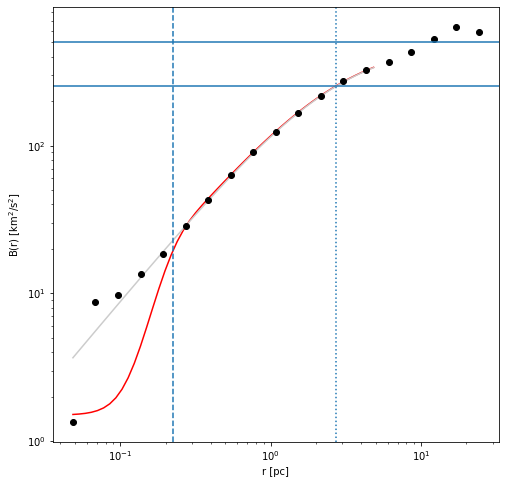

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axhline(2*sig2)
ax.axvline( 2.355  * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)


sig2,r0

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.05
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 4.0
weights[0] /= 2.0
weights[1] /= 8.0
weights[2] /= 4.0
weights[3] /= 2.0
#weights[4] /= 1.5

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1, sig2=sig2,
)

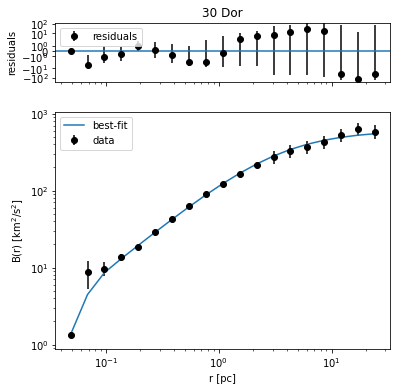

In [10]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title='30 Dor',
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"


plt.savefig('SFpaper//30Dor.pdf', bbox_inches='tight')


In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 19
    # variables        = 5
    chi-square         = 5.68387750
    reduced chi-square = 0.40599125
    Akaike info crit   = -12.9293011
    Bayesian info crit = -8.20710621
[[Variables]]
    r0:     3.41263398 +/- 0.38211293 (11.20%) (init = 2.721777)
    sig2:   300.675498 +/- 24.3474028 (8.10%) (init = 252.1136)
    m:      1.18259508 +/- 0.02365037 (2.00%) (init = 1.22)
    s0:     0.02940382 +/- 0.02166445 (73.68%) (init = 0.09453928)
    noise:  1.1059e-08 +/- 2.52122430 (22798678136.27%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise) =  0.999
    C(r0, sig2)  =  0.969
    C(r0, m)     = -0.871
    C(sig2, m)   = -0.742
    C(m, s0)     = -0.196
    C(m, noise)  = -0.176
    C(r0, s0)    =  0.136
    C(r0, noise) =  0.121
    C(sig2, s0)  =  0.108


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.0 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -1.15413  -0.76903  -0.39049   3.41263  +0.44791  +1.02832  +1.89677
 sig2 : -79.50270 -51.12581 -25.43248 300.67550 +27.97372 +62.51913+111.10041
 m    :  -0.02021  -0.01627  -0.01622   1.18260  +0.02567  +0.05933  +0.10600
 s0   :  -0.00203  -0.00127  -0.00062   0.02940  +0.00238  +0.00827  +0.01639
 noise:      -inf      -inf      -inf   0.00000      +inf      +inf      +inf


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:319: UserWarning: maxiter=200 reached and prob(noise=0.2010000110586426) = 0.5554410438776095 < max(sigmas).
  warn(errmsg)


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 0.07],
    "m": [1.1, 1.4],
    "r0": [2.0, 3.5],
    "noise": [0.0, 2.0],
    "sig2": [270, 350],
}

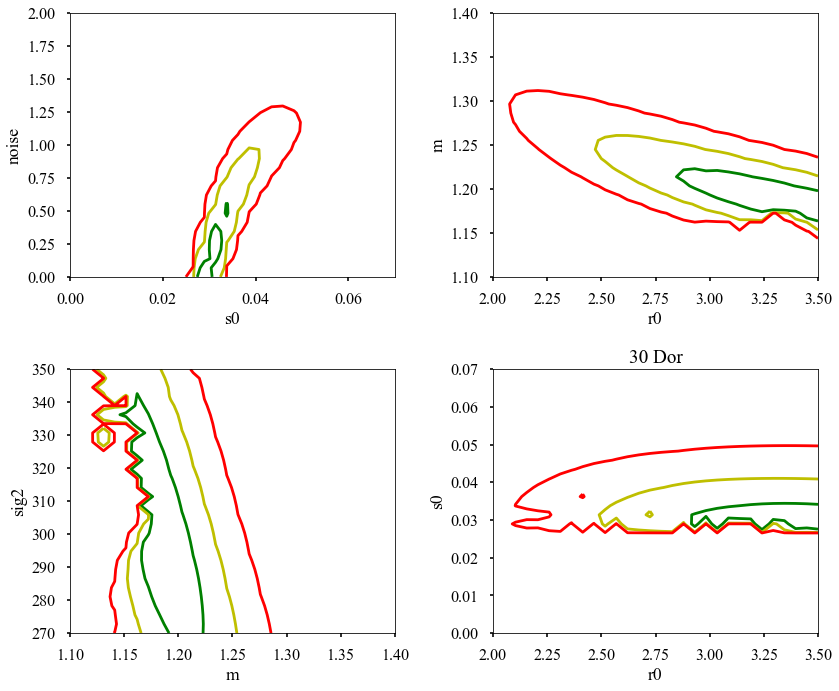

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('30 Dor')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "sig2"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
x=r
y=B-2*sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([11.26122938])

In [18]:
r.max()/result2.params['r0'].value

7.108134729307205

In [19]:
(r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))

0.6473047716612845

In [20]:
#f = open('CI//30DCI.pkl',"wb")
#pickle.dump(result2,f)
#f.close()

In [21]:
#pickle_in = open('30DCI.pkl',"rb")
#CI = pickle.load(pickle_in)

In [22]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 39.29457426071167 seconds ---
